<a href="https://colab.research.google.com/github/TangJiahui/6.036_Machine_Learning/blob/main/MIT_6_036_HW12_Decision_Tree_Classifiers_and_Nearest_Neighbour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Homework 12


In [35]:
!rm -rf code_for_hw12* __MACOSX data .DS_Store
!wget --quiet https://introml.odl.mit.edu/cat-soop/_static/6.036/homework/hw12/code_for_hw12.zip --no-check-certificate
!unzip -q code_for_hw12.zip
!mv code_for_hw12/* .
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression, ElasticNet, LinearRegression
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

# 1) Decision Trees

## Implementing Modules of Binary Decision Tree Classfiers


**1.1** We first take a look at some implementing some modules of decision trees for 2D data. We will implement how a decision tree assigns labels to a split by first determining where to split it based off weighted average entropy as a metric. We will be implementing some modules for a binary decision tree classifier. For these impelmentations, we'll be looking at binary classification.



###Calculating Entropy of a Dataset
Since we are using entropy as a metric, we want to implement a function that calculates the entropy of a dataset. Recall the formula of entropy from the [notes](https://introml.odl.mit.edu/cat-soop/_static/6.036/LectureNotes/chapter_Non-parametric_methods.pdf): if $\hat{P}_{mk}$ denotes the empirical probability of seeing class $k$ in region $m$, the entropy over the region is

$$-\sum_k\hat{P}_{mk} \log_2 \hat{P}_{mk}$$

In ```calculate_entropy(data, labels)```, ```data``` is a size $n$ list of 2D data points and ```labels``` is a size $1\times n$ vector of the corresponding labels, which is either 1 or -1. Implement a function that calculates the entropy over all of the datapoints in ```data.```



In [ ]:
def calculate_entropy(data, labels):
    """
      Parameters:
          data is a size n list of data points (x1, x2)
          entropy is a 1 by n array of the labels corresponding to the datapoints in data
      Returns:
          A float denoting the entropy in the dataset.
    """
    if len(data) == 0:
        return 0
    p_1, p_0 = 0,0
    for i in range(len(data)):
        if labels[0][i] == 1:
            p_1 += 1
        else:
            p_0 += 1
    p_1 = p_1/len(data)
    p_0 = 1-p_1
    if p_1 == 0 or p_0 == 0:
        return 0
    else:
        return  -(p_0*math.log2(p_0) + p_1*math.log2(p_1))

In [ ]:
## test cases for calculate entropy
def test_calculate_entropy():
    num_passed = 0
    data1 = [(1, 1), (2, 4), (3, 5)]
    labels1 = np.array([[1, 1, 1]])
    expected1 = 0
    actual1 = calculate_entropy(data1, labels1)
    if expected1 == actual1:
      num_passed += 1
    else:
      print("failed test case 1")

    data2 = [(0, 1), (3, 2), (5, 9), (3, 4)]
    labels2 = np.array([[1, 1, -1, -1]])
    expected2 = 1
    actual2 = calculate_entropy(data2, labels2)
    if expected2 == actual2:
      num_passed += 1
    else:
      print("failed test case 2")

    data3 = [(5, 6), (2, 1), (2, 2), (6, 99), (2, 3)]
    labels3 = np.array([[-1, 1, -1, -1, 1]])
    expected3 = 0.9709505945
    actual3 = calculate_entropy(data3, labels3)
    if (abs(actual3-expected3))<1e-5:
      num_passed += 1
    else:
      print("failed test case 3")

    data4 = [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6)]
    labels4 = np.array([[1, 1, 1, 1, -1, 1]])
    expected4 = 0.6500224216
    actual4 = calculate_entropy(data4, labels4)
    if (abs(actual4-expected4))<1e-5:
      num_passed += 1
    else:
      print("failed test case 4")

    print("%s/4 tests passed for calculate_entropy" %num_passed)
test_calculate_entropy()

4/4 tests passed for calculate_entropy


###Finding the best split of a dataset
Now, we would like to find what the best split of the dataset we should take. Remember when using entropy as a critereon, we want to find the split that minimizes the weighted average of the entropy of the two datasets of the split. Since we're in two dimensions, we can either split in the $x_1$ direction or the $x_2$ direction, so ```find_best_split(data, labels)``` should return a tuple where the first element is the axis of the split, either "x1" or "x2" and the second element should be the value of the place to split. Assume that we will split exactly halfway between two datapoints in the dataset ```data```.

Note that there is a $O(dn\log(n))$ solution, where $d$ is the number of features in the dataset and $n$ is the number of datapoints, but we will accept a solution of any runtime. Having an efficient runtime is what makes decision trees so easy to train.

Look at the catsoop problem for pseudocode.

In [ ]:
def find_best_split(data, labels):
    """
      Parameters:
          data is a size n list of data points (x1, x2)
          labels is a 1 by n array of the labels corresponding to the datapoints in data
      Returns:
          A tuple where the first element denotes the axis of the split, either "x1" or "x2" and the second element denotes the value of the place to split along the axis
    """
    min_entropy = None
    best_split = None
    split_axis = None
    # loop over potential feature axes
    for i in range(len(data[0])):
        coords = [data[j][i] for j in range(len(data))]
        coords_sorted = sorted(set(coords))
        for pos in range(len(coords_sorted)-1):
            split = (coords_sorted[pos] + coords_sorted[pos+1])/2
            left_child, left_label, right_child, right_label = [], [], [], []
            for j in range(len(data)):
                d = data[j]
                if d[i] < split:
                    left_child.append(d)
                    left_label.append(labels[0][j])
                else:
                    right_child.append(d)
                    right_label.append(labels[0][j])
            def _entropy(child, label):
                return len(child)/len(data)*calculate_entropy(child, np.array([label])) if len(child) > 0 else 0
            weighted_entropy = _entropy(left_child, left_label) + _entropy(right_child, right_label)
            # print(split, i, weighted_entropy)
            if (min_entropy is None) or (weighted_entropy < min_entropy):
                min_entropy = weighted_entropy
                best_split = split
                split_axis = "x"+str(i+1)
    return (split_axis, best_split)

In [ ]:
def _whatever():
    data = [(0, 1), (1, 1)]
    labels = np.array([[-1, 1]])
    print(find_best_split(data, labels))

_whatever()

0.5 0 0.0
('x1', 0.5)


In [ ]:
# test cases for find_best_split
def test_find_best_split():
    num_passed = 0
    data1 = [(0, 1), (3, 2), (5, 9), (3, 4)]
    labels1 = np.array([[1, 1, -1, -1]])
    expected1 = ("x2", 3)
    actual1 = find_best_split(data1, labels1)
    print(actual1)
    if(actual1 == expected1):
      num_passed+=1
    else:
      print("failed test case 1")

    data2 = [(5, 6), (2, 1), (2, 2), (6, 99), (2, 6)]
    labels2 = np.array([[-1, 1, -1, -1, 1]])
    expected2 = ("x1", 3.5) 
    actual2 = find_best_split(data2, labels2)
    print(actual2)
    if actual2 == expected2:
      num_passed += 1
    else:
      print("failed test case 2")

    data3 = [(-100, 0), (0, -5), (2, 3), (5, 10), (100, 2)]
    labels3 = np.array([[-1, 1, 1, 1, 1]])
    expected3 = ("x1", -50)
    actual3 = find_best_split(data3, labels3)
    print(actual3)
    if expected3 == actual3:
      num_passed += 1
    else:
      print("failed test case 3")

    data4 = [(-3, 1), (-2, 1), (-2, -1), (2, 1), (3, 1), (3, -1)]
    labels4 = np.array([[1, 1, 1, 1, -1, 1]])
    expected4 = ("x1", 2.5) 
    actual4 = find_best_split(data4, labels4)
    print(actual4)
    if expected4 == actual4:
      num_passed += 1
    else:
      print("failed test case 4")

    print("%s/4 test cases passed"%num_passed)
test_find_best_split()


('x2', 3.0)
('x1', 3.5)
('x1', -50.0)
('x1', 2.5)
4/4 test cases passed


###Determining what label to assign a split
Now that we have a function to find the best splits of the dataset, we want ot be able to make a decision rule based off of that split. Given a set of datapoints that are set to be in the same partition, return the predicted label of that partition in ```return_label(data, labels).``` 

In [ ]:
def return_label(data, labels):
    """
      Parameters:
          data is a size n list of data points (x1, x2)
          labels is a 1 by n array of the labels corresponding to the datapoints in data
      Returns:
          a label, either 1 or -1, denoting what label to assign for the partition over data, labels
    """
    if np.sum(labels)>0:
        return 1
    else:
        return -1

In [ ]:
#test cases for return_label
def test_return_label():
    num_passed = 0
    data1 = [(0, 1), (3, 2), (5, 9), (3, 4), (2, 4)]
    labels1 = np.array([[1, 1, -1, -1, 1]])
    expected1 = 1
    actual1 = return_label(data1, labels1)
    if(actual1 == expected1):
      num_passed+=1
    else:
      print("failed test case 1")

    data2 = [(5, 6), (2, 1), (2, 2), (6, 99), (2, 3)]
    labels2 = np.array([[-1, 1, -1, -1, 1]])
    expected2 = -1
    actual2 = return_label(data2, labels2)
    if actual2 == expected2:
      num_passed += 1
    else:
      print("failed test case 2")

    data3 = [(-100, 0), (0, 5), (2, 3), (5, 10), (100, 2)]
    labels3 = np.array([[-1, 1, 1, 1, 1]])
    expected3 = 1
    actual3 = return_label(data3, labels3)
    if expected3 == actual3:
      num_passed += 1
    else:
      print("failed test case 3")

    data4 = [(-3, 1), (-2, 1), (-2, -1), (2, 1), (3, 1), (3, -1)]
    labels4 = np.array([[1, 1, 1, 1, -1, 1]])
    expected4 = 1
    actual4 = return_label(data4, labels4)
    if expected4 == actual4:
      num_passed += 1
    else:
      print("failed test case 4")
    print("%s/4 test cases passed"%num_passed)
test_return_label()

4/4 test cases passed


###Putting it all together
Now that we have all the modules implemented, we would like to put it all together to create a two-layer decision tree. In `predict_datapoint(data, labels, datapoint)` you should construct a two layer decision tree based on `data` and `labels` and use that tree to assign a label to `datapoint`. You can assume that there will be at least one datapoint in each partition found by the decision tree. Note that there is a `depth` parameter in case that you want to implement a recursive function, but the test cases will all have `depth = 2` in case you do not want to implement the function recursively. Here a depth of 2 means a total tree height of 3, including the leaf nodes.

In [ ]:
def predict_datapoint(data, labels, datapoint, depth = 2):
    """
      Parameters: 
          data is a size n list of datapoints (x1, x2)
          labels is a 1 by n array of labels corresponding to the datapoints in data
          datapoint is a tuple (x1, x2)
      Returns:
          A label, either -1 or 1, denoting what label to assign datapoint using a two-layer decision tree trained on data, labels
    """
    # split data and label at current level
    axis, split = find_best_split(data, labels)
    left_data, left_label = [], []
    right_data, right_label = [], []
    for i in range(len(data)):
        if data[i][int(axis[-1]) - 1]< split:
            left_data.append(data[i])
            left_label.append(labels[0][i])
        else:
            right_data.append(data[i])
            right_label.append(labels[0][i])

    # recursion
    if depth <= 1: 
        if datapoint[int(axis[-1]) - 1]< split:
            return return_label(left_data, np.array([left_label]))
        else:
            return return_label(right_data, np.array([right_label]))
    else:
        print(left_data, left_label)
        print(right_data, right_label)
        if datapoint[int(axis[-1]) - 1]< split:
            return predict_datapoint(left_data, np.array([left_label]), datapoint, depth-1)
        else:
            return predict_datapoint(right_data, np.array([right_label]), datapoint, depth-1)

In [ ]:
#two level decision tree
def test_predict_datapoint():
    num_passed = 0 
    #xor
    data = [(0, 0), (1, 0), (0, 1), (1, 1)]
    labels = np.array([[1, -1, -1, 1]])
    datapoint = (2, 2)
    expected = 1
    actual = predict_datapoint(data, labels, datapoint, 2)
    if expected == actual:
      num_passed += 1
    else:
      print("failed test case 1")

    data = [(1, 2), (3, 2), (2, 3.5), (1, 5), (2, 6), (6, 3)]
    labels = np.array([[1, -1, -1, 1, -1, 1]])
    datapoint = (3, 0)
    expected = -1
    actual = predict_datapoint(data, labels, datapoint, 2)
    if expected == actual:
      num_passed += 1
    else:
      print("failed test case 2")
    
    datapoint = (1, -1000)
    expected = 1
    actual = predict_datapoint(data, labels, datapoint, 2)
    if expected == actual:
      num_passed += 1
    else:
      print("failed test case 3")
    
    data = [(0.57357417, 0.90217185), (0.76566003, 0.76527182), (0.59400348, 0.83215993),(0.86183616 ,0.58866857),(0.14435413, 0.16789092),\
            (0.66148572, 0.88929846), (0.72530673, 0.73518614), (0.89829273, 0.3936054 ), (0.52575489 ,0.95595477), (0.56629658 ,0.79039303)]
    labels = np.array([[1, -1, 1, 1, 1, -1, -1, 1, 1, -1]])
    datapoint = (100, 0.5)
    expected = 1
    actual = predict_datapoint(data, labels, datapoint, 2)
    if expected == actual:
      num_passed += 1
    else:
      print("failed test case 4")
    datapoint = (1.2934, 0.75)
    expected = -1
    actual = predict_datapoint(data, labels, datapoint, 2)
    if actual == expected:
      num_passed += 1
    else:
      print("failed test case 5")
    print("%s/5 test cases passed"%num_passed)

test_predict_datapoint()

[(0, 0), (0, 1)] [1, -1]
[(1, 0), (1, 1)] [-1, 1]
[(1, 2), (1, 5)] [1, 1]
[(3, 2), (2, 3.5), (2, 6), (6, 3)] [-1, -1, -1, 1]
[(1, 2), (1, 5)] [1, 1]
[(3, 2), (2, 3.5), (2, 6), (6, 3)] [-1, -1, -1, 1]
[(0.86183616, 0.58866857), (0.14435413, 0.16789092), (0.89829273, 0.3936054)] [1, 1, 1]
[(0.57357417, 0.90217185), (0.76566003, 0.76527182), (0.59400348, 0.83215993), (0.66148572, 0.88929846), (0.72530673, 0.73518614), (0.52575489, 0.95595477), (0.56629658, 0.79039303)] [1, -1, 1, -1, -1, 1, -1]
[(0.86183616, 0.58866857), (0.14435413, 0.16789092), (0.89829273, 0.3936054)] [1, 1, 1]
[(0.57357417, 0.90217185), (0.76566003, 0.76527182), (0.59400348, 0.83215993), (0.66148572, 0.88929846), (0.72530673, 0.73518614), (0.52575489, 0.95595477), (0.56629658, 0.79039303)] [1, -1, 1, -1, -1, 1, -1]
5/5 test cases passed


##Decisions, decisions, decisions...
In this section, we will be looking at a dataset that aims to determine whether a wine is of good quality or bad quality based off of some features. We'll train a decision tree for our classification problem here. We first load in the data.


In [ ]:
all_data = pd.read_csv("winequality-red.csv", sep=";")
all_data.loc[all_data["quality"] <= 5, "quality"] = 0
all_data.loc[all_data["quality"] > 5, "quality"] = 1

In [ ]:
features = all_data.columns[:-1]
print(features)
wine_data = all_data[features]
wine_labels = all_data[["quality"]]

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol'],
      dtype='object')


In [ ]:
train_wine_data, test_wine_data, train_wine_labels, test_wine_labels =\
   train_test_split(wine_data, wine_labels, stratify = wine_labels, test_size = 0.3, random_state = 20) #do not touch random state

###Hyperparameter Search
Tuning parameters is very important when training decision trees because we run the risk of overfitting. For this reason, we'll have to use cross validation to ensure that the parameters we're setting in our decision tree not only works for our training data but validation data as well. We'll use sci-kit learn's [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) package as our model and use [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) to run a parameter search to find our optimal parameters.

We can first define what parameters we want to search over, and what the values we should try are. GridSearchCV will try all possible combinations of these parameter settings and save which parameters do the best. Specifically, we will try different values for `criterion`, `min_samples_split`, `min_samples_leaf`, and `max_depth`. Please read the documentation in DecisionTreeClassifier to understand what these parameters are.


In [ ]:
#decision tree params
dt_params = {
    "criterion":["gini", "entropy"],
    "min_samples_split": [2, 5, 10, 50, 100, 150, 200, 300], 
    "min_samples_leaf": [2, 5, 10, 20, 100, 150, 200, 250],
    "max_depth": [3, 5, 10, 50, 100]
}

####Conceptual Questions
1) How does increasing min_samples_split affect training accuracy? Test accuracy?

2) How does increasing min_samples_leaf affect training accuracy? Test error?

3) How does increasing max_depth affect training accuracy? Test error?


Look at the GridSearchCV documentation and DecisionTreeClassifier documentation to run a hyperparameter search on the wine dataset. Search over the space defined in `dt_params`. For the next section, due to the stochastic nature of creating training and test datasets, multiple solutions are accepted. If you believe that your method is correct but the solution isn't being accepted, please post a private message directed to staff on Discourse with your methodology and results.

In [ ]:
#use GridSearchCV to find the best parameters
gdsearch = GridSearchCV(DecisionTreeClassifier(), dt_params)
gdsearch.fit(train_wine_data, train_wine_labels)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini', 'entropy'],
                

In [ ]:
best_params =  gdsearch.best_params_
#cv_results_['params'](gdsearch.cv_results_['rank_test_score'].index(1))
print(best_params)

#Now we will use all of the training data to relearn a decision classifier
decision_clf = DecisionTreeClassifier(**best_params)
decision_clf.fit(train_wine_data, train_wine_labels)
print(decision_clf.score(test_wine_data, test_wine_labels)) #find the score of the test data, metric is mean accuracy from docs

{'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 20, 'min_samples_split': 50}
0.71875


Now, we will use sci-kit learn's [plot tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html) to visualize our learned decision tree.

As an example, if our node is 


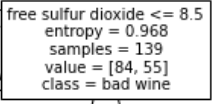

this means we are splitting along the "free sulfur dioxide" feature, there are 84 wines in this node that are classified as bad wine and 55 wines in this node that are classified as good wine. Thus, we output the label bad wine for this node.

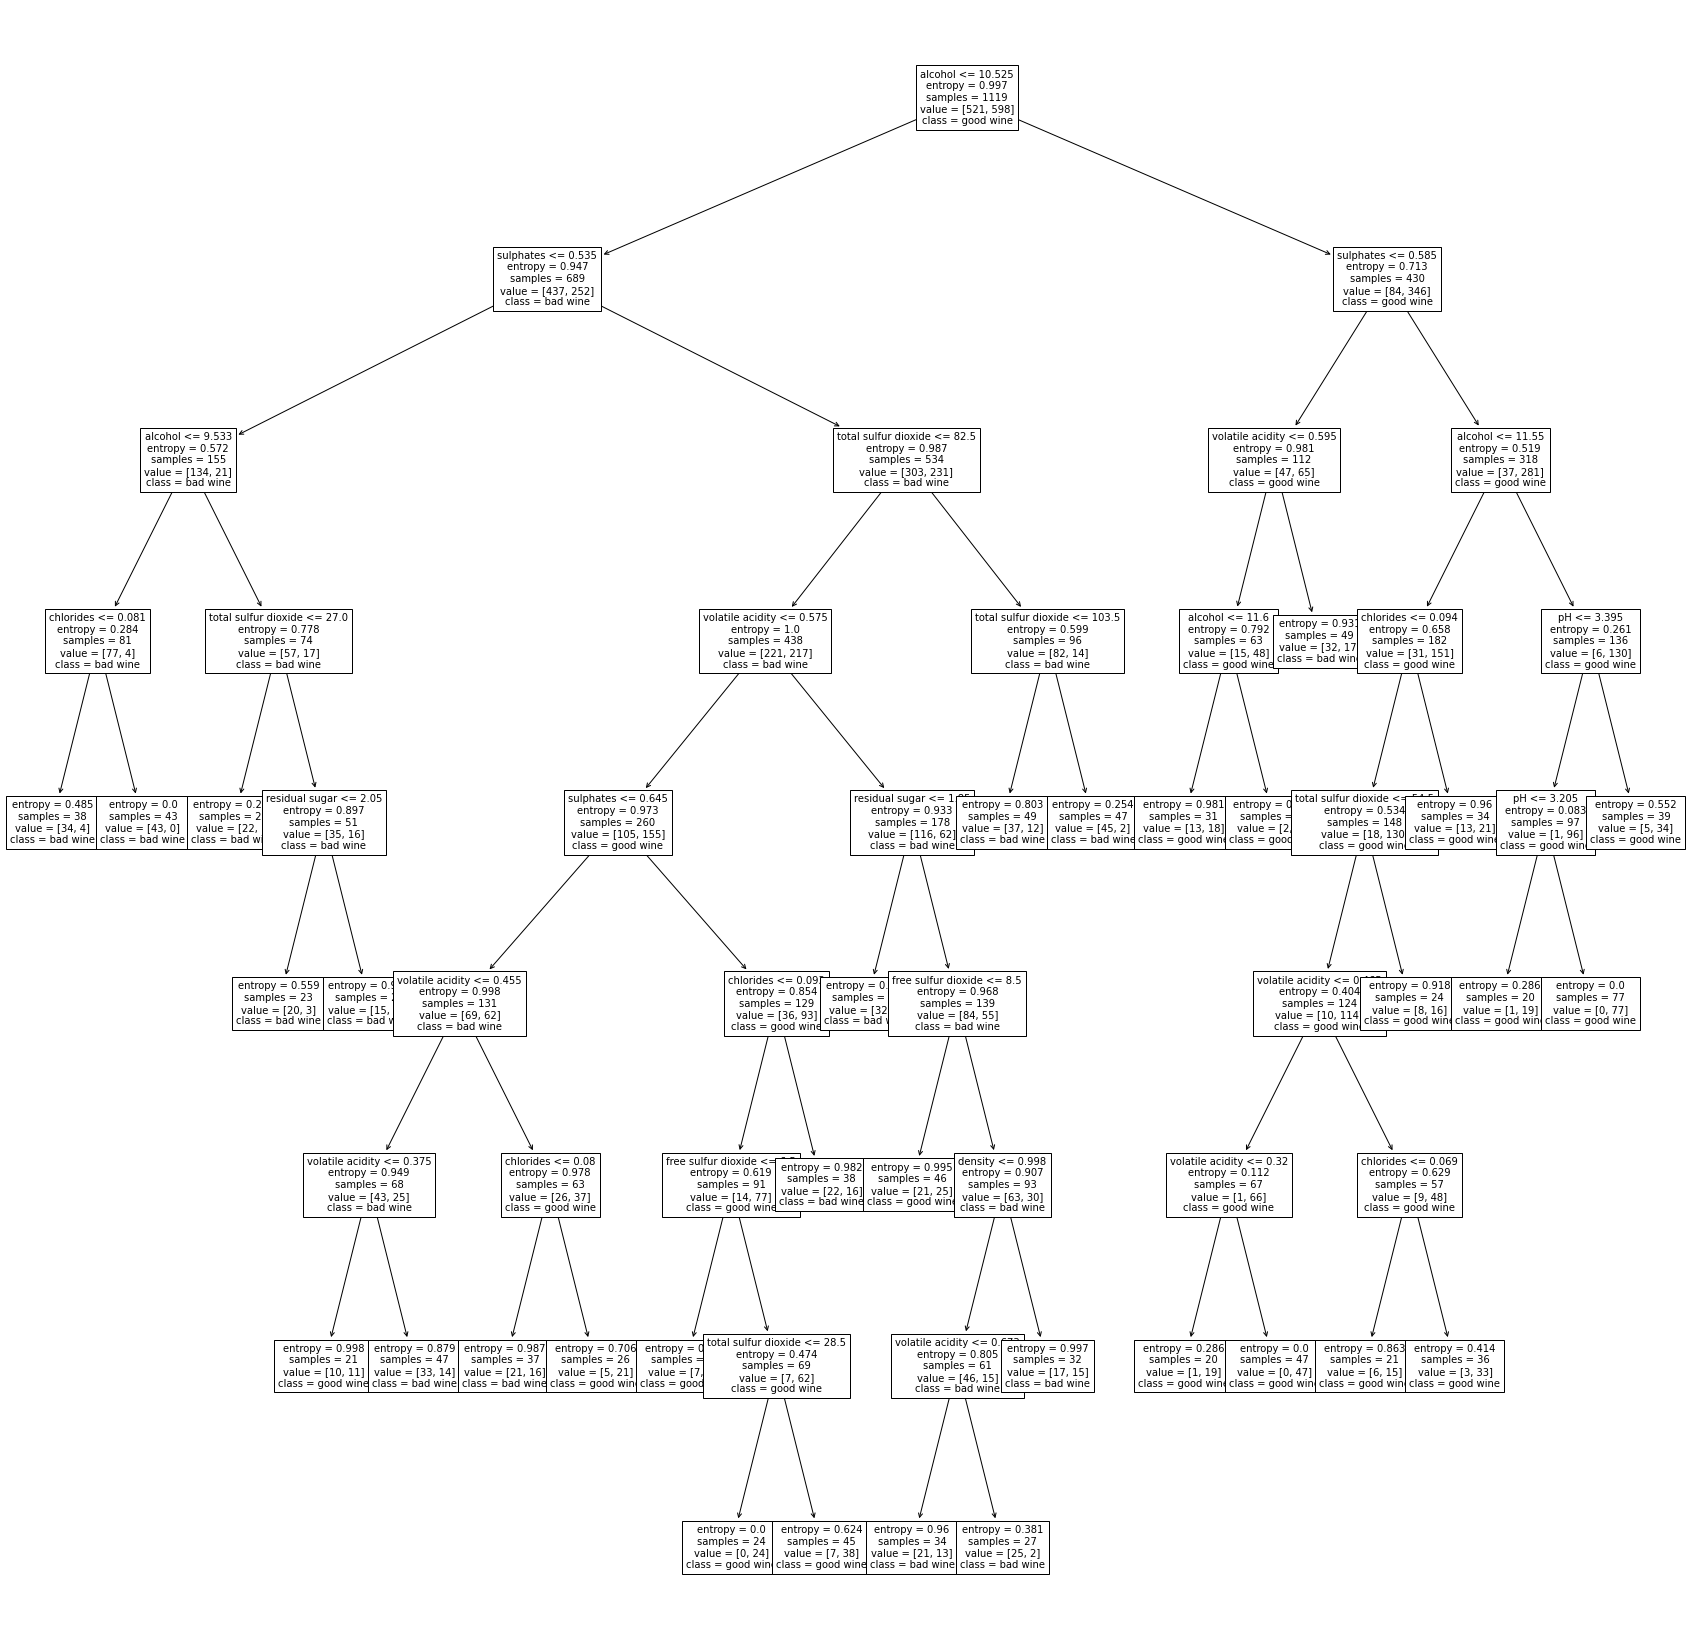

In [ ]:
# #visualize the tree
fig, ax = plt.subplots(figsize=(30, 30))
plot = plot_tree(decision_clf, feature_names = features, class_names=["bad wine", "good wine"], fontsize=10, ax=ax)

In [ ]:
decision_clf.feature_importances_

array([0.        , 0.12433033, 0.        , 0.02248815, 0.08783067,
       0.01883791, 0.12451311, 0.00762518, 0.01856482, 0.18255612,
       0.4132537 ])

Answer the questions on catsoop about the interpretation of this tree.

###Logistic Regression Hyperparameter Search
Now, we want to compare our decision tree to a logistic regression to see if the decision tree is picking up some nonlinearities in the dataset. We do the same thing for a logistic regression: we first run a hyperparameter search for the best parameters for [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and compare the accuracies and interpretations. Please read the documentation for LogisticRegression to understand the settings in `lr_params`.

In [ ]:
lr_params = {
        "penalty":["l1", "l2"],
        "C":[1e-3, 1e-2, 1e-1, 1, 5, 10, 100, 250],
        "solver": ["liblinear"]
}

####Conceptual Questions
How does increasing $C$ affect training accuracy? Testing accuracy?

Now, run a hyperparameter search using GridSearchCV again, but for a logistic regression. 

In [ ]:
#reshape train_wine_labels to be 1D
train_wine_labels_1d = np.array(train_wine_labels).reshape(len(train_wine_labels),)
#todo: hint, you might want to use train_wine_labels_1d as the input to this GridSearchCV, why?

In [ ]:
gdsearch_log = GridSearchCV(LogisticRegression(), lr_params)
gdsearch_log.fit(train_wine_data, train_wine_labels_1d)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 5, 10, 100, 250],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
lr_best_params = gdsearch_log.best_params_
print(lr_best_params)
lr_classifier = LogisticRegression(**lr_best_params)
lr_classifier.fit(train_wine_data, train_wine_labels_1d)
print(lr_classifier.score(test_wine_data, test_wine_labels))

{'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
0.7458333333333333


Similarly to when analyzing decision trees, we would like to determine which features play the most important role in classifying whether a wine is good or bad. Take a look at the coefficients of this model and determine which feature is the most important to classifying a good wine vs a bad wine. 

In [ ]:
lr_coefficients = lr_classifier.coef_
# get the weights of the features of the wine data
sorted_coeff_indices = np.argsort(np.abs(lr_coefficients))
for i in sorted_coeff_indices[0]:
    print("%s: %s" %(features[i], lr_coefficients[0][i]))

total sulfur dioxide: -0.017022993820867686
free sulfur dioxide: 0.027022878080239992
residual sugar: 0.0368221592401041
fixed acidity: 0.11479499289946744
pH: -0.3374238780726794
alcohol: 0.9002675230492709
citric acid: -1.2621056198434166
chlorides: -2.3646664573020373
sulphates: 2.494674213108551
volatile acidity: -3.6611217008251096
density: -3.959096366408901


However, the coefficients as is don't provide much intuition on how important the features are, since the features could be of different scale. So if we have features that naturally take on very large values, they may artificially get a small coefficient. For that reason, we scale the data inputs and take a look at the coeffiecients of the scaled features.

Now, what is the most important feature?

In [ ]:
lr_classifier_scaled = LogisticRegression(**lr_best_params)
lr_classifier_scaled.fit(scale(train_wine_data), train_wine_labels_1d)
print(lr_classifier_scaled.score(scale(test_wine_data), test_wine_labels))

0.7395833333333334


In [ ]:
lr_coefficients_scaled = lr_classifier_scaled.coef_
# get the weights of the scaled features of the wine data
sorted_coeff_indices = np.argsort(np.abs(lr_coefficients_scaled))
for i in sorted_coeff_indices[0]:
    print("%s: %s" %(features[i], lr_coefficients_scaled[0][i]))

density: -0.009953760086432806
pH: -0.02629624292652435
residual sugar: 0.056231274784732097
chlorides: -0.12151742441599497
fixed acidity: 0.22271835122153782
citric acid: -0.2534815551301575
free sulfur dioxide: 0.27172400244768113
sulphates: 0.4272338765591157
total sulfur dioxide: -0.5493714136046729
volatile acidity: -0.6549447717954824
alcohol: 0.9767109177454277


While we're still able to determine what features are important in classifying whether a wine is good or bad, we have no sense of what values these features need to take to classify whether a wine is good or bad, like we were able to do in a decision tree.

###Random Forest Hyperparameter Search
Finally, we do the same hyperparameter search for a random forest. Use GridSearchCV again to find the best setting of parameters from `rf_params`. Performing this search may take some time (around 5-10 minutes), so be patient! When initializing `RandomForestClassifier`, please use a random state of 10, to ensure that the output stays consistent with the solutions on Catsoop! 




In [ ]:
rf_params = {
    "n_estimators":[50, 200],
    "criterion":["gini", "entropy"],
    "max_depth":[2, 10, 50],
    "min_samples_leaf":[2,10,50]
}

In [ ]:
#todo: run a hyperparameter search over rf_params for a random forest here
gdsearch_rf = GridSearchCV(RandomForestClassifier(random_state=10), rf_params)
gdsearch_rf.fit(train_wine_data, train_wine_labels_1d)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=10,
                               

In [ ]:
rf_best_params = gdsearch_rf.best_params_
print(rf_best_params)
rf_clf = RandomForestClassifier(**rf_best_params, random_state = 10) #do not touch random state
rf_clf.fit(train_wine_data, train_wine_labels_1d)
print(rf_clf.score(test_wine_data, test_wine_labels))

{'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 2, 'n_estimators': 200}
0.7916666666666666


We see that a big advantage of using sci-kit learn is its ability to quickly switch out different models we would like to use. All we need to change is the hyperparameters we want to search over and the model input to GridSearchCV!




# 2) Nearest Neighbors

See the MITx page for conceptual (non-coding) questions.

# 3) Nearest Neighbor Implementation


Implement the following distance functions below according to their specifications. They should compute the pairwise distance between a single sample of dimension (d,1)(d,1) and nn individual samples, each with dimension (d,1)(d,1), in an array of dimension (d,n)(d,n). This will make it easy to compute the distances between a single test sample and the entire training set in KNN. Numpy is preloaded for you, but you can't use np.linalg.norm.

A) Implement the Euclidean distance below. Remember that the Euclidean distance between two dd-dimensional vectors is defined as :

$$E(p,q) = \sqrt{\sum_{i=1}^{d}(p_i - q_i)^2}$$

 


In [37]:
def euclidean(a, b):
    """
    Parameters:
        a is d by n array
        b is d by 1 array
    Returns :
        (n,) array: the pairwise Euclidean distance of b with respect to individual samples in  a
    """
    result = []
    for i in range(a.shape[1]):
        result.append(np.sqrt(np.sum((a[:,i:i+1]-b)**2)))
    return np.array(result)

In [ ]:
a = np.array([[0,1,1,-4,-2],[0,1,2,9,-2]])
b = np.array([[-2],[1]])
euclidean(a,b)

array([2.23606798, 3.        , 3.16227766, 8.24621125, 3.        ])

B)Implement the Manhattan distance below. Remember that the Manhattan distance between two d-dimensional vectors is defined as :

$$M(p,q) = \sum_{i=1}^{d}|p_i - q_i|$$


In [38]:
def manhattan(a,b):
    """
    Parameters:
        a is d by n array 
        b is d by 1 array
    Returns :
        (n,) array: the pairwise Manhattan distance of b with respect to individual samples in  a
    """
    result = []
    for i in range(a.shape[1]):
        result.append(np.sum(np.abs(a[:,i:i+1]-b)))
    return np.array(result)

C) Implement the KNN class for classification below according to its specifications. Some functions that may come in handy are `np.argsort` and `np.bincount`. If you need a refresher on how KNNs work for classification, take a look at [the notes](https://lms.mitx.mit.edu/assets/courseware/v1/f0cc0c187c20a52b6ca4d967efdca4f0/asset-v1:MITx+6.036+2020_Fall+type@asset+block/notes_chapter_Non-parametric_methods.pdf). 

In [12]:
class KNN:
    """ KNN for classification"""
    def __init__(self, K, distance_metric, trainX, trainY):
        """
        Parameters:
            K is an int representing the number of closest neighbors to consider
            distance_metric is one of euclidean or manhattan
            trainX is d by n array
            trainY is 1 by n array
        """
        self.trainX = trainX
        self.trainY = trainY
        self.K = K
        self.metric = distance_metric
        
    def calc_distances(self, testX):
        """
        Parameters:
            testX is d by m array
        Returns:
            an m x n array D where D[i, j] is the distance between test sample i and train sample j
        """
        D = []
        for j in range(self.trainX.shape[1]):
            D.append(self.metric(testX, self.trainX[:, j:j+1]))
        return np.array(D).T

    def find_top_neighbor_labels(self, dists):
        """
        Parameters:
            dists is  m x n array D where D[i, j] is the distance between test sample i and train sample j
        Returns:
            an m x K array L where L[i, j] is the label of the jth closest neighbor to test sample i
            in case of ties, the neighbor which appears first in the training set is chosen
        """
        result = []
        for row in range(dists.shape[0]):
            idx = np.argsort(dists[row:row+1,], axis = 1)
            result.append(self.trainY[0][idx][0][:self.K])
        return np.array(result)

     
    def predict(self, testX):
        """
        Parameters:
            testX is d by m array
        Returns:
            predicted is (m,) array P where P[i] is the predicted label for test sample i 
        """
        d = self.calc_distances(testX)
        knn = self.find_top_neighbor_labels(d)
        predicted = []
        for row in range(knn.shape[0]):
            predicted.append(np.argmax(np.bincount(knn[row,:])))
        return np.array(predicted)

    def score(self, testX, testY):
        """
        Parameters:
            testX is d by m array of input data
            testY is 1 by m array of labels for the input data
        Returns:
            a scalar: the accuracy of the KNN predictions across the test set
        """
        pred = self.predict(testX)
        return np.sum(pred == testY[0])/len(testY[0])

# 4) NN: Nearest Neighbors or Neural Networks?


Now that we have implemented our K-Nearest Neighbors algorithm, we can test how well it does on Scikit-learn's MNIST dataset.

First, we need to process data to fit our class standards. Scikit-learn's input data take the form $(n,d)$ and labels take the form $(n,)$. Implement the function below so that the data can be fed into our KNNs (refer back to the KNN specifications above if you don't remember the needed shapes).


In [36]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

mnist = datasets.load_digits()
train_data, test_data, train_labels, test_labels = train_test_split(np.array(mnist.data), mnist.target, test_size=0.25, random_state=42)

In [7]:
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(np.array([test_labels]).shape)

(1347, 64)
(450, 64)
(1347,)
(1, 450)


In [39]:
def process_data_for_knn(train_data, test_data, train_labels, test_labels):
    trainX = train_data.T
    testX = test_data.T
    trainY = np.array([train_labels])
    testY = np.array([test_labels])
    return trainX, testX, trainY, testY

Now we'll evaluate the KNN accuracy on various values of K using Euclidean distance and compare its performance to a simple neural network.

**4A)** What is the accuracy of KNN using Euclidean distance on the MNIST dataset for K=1, 3, 5?


In [40]:
trainX, testX, trainY, testY = process_data_for_knn(train_data, test_data, train_labels, test_labels)
for K in (1,3,5):
    knn = KNN(K, euclidean, trainX, trainY)
    print(knn.score(testX, testY))

0.9822222222222222
0.9866666666666667
0.9933333333333333


Use the code below to test how well a simple Neural network with two hidden layers, of sizes 50 and 5, performs. 

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
import warnings
from sklearn.exceptions import ConvergenceWarning

norm_train_data, norm_test_data = train_data/16, test_data/16
mlp = MLPClassifier(hidden_layer_sizes=(50,5), max_iter=10000, alpha=1e-4, solver='sgd', verbose=None, random_state=1,learning_rate_init=.1)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp.fit(norm_train_data, train_labels)
    print(mlp.score(norm_test_data, test_labels))

0.9688888888888889


**4B)** What is the accuracy of the provided Neural Network on the MNIST dataset?


**4C)** What performs marginally better on this simple dataset: nearest neighbors or neural networks?

# 5) Nearest Neighbors for Few-Shot Learning


One of the major benefits of KNNs that we hinted at during lab 7 is that they can do surprisingly well in few-shot
learning settings, where only a few labeled examples are available. More specifically, we hypothesized that by doing KNNs on embeddings of the examples provided by an auto-encoder, we could get a great performance with ony a few single labeled examples. Let's put it to the test!


We first start by training an auto-encoder. Because we want to test the KNN, not the auto-encoder itself, we will use the entire dataset to train the auto-encoder and produce the embeddings. As always for neural nets, we standardize the data first.

In [41]:
mnist = datasets.load_digits()
all_data, _, all_labels, _ = train_test_split(np.array(mnist.data), mnist.target, test_size=0.01, random_state=42)
all_data = all_data/16  #max int is 16

In [46]:
all_labels

array([8, 8, 4, ..., 2, 7, 1])

**5A)** To simplify the task a little bit, we will only keep 2 classes: zeros and twos. Complete the function below, which takes in a list of integers corresponding to the classes we want to keep, and returns that subset of the data and labels with only those classes. The numpy function `isin` might come in handy.

In [65]:
def keep_subset_classes(data, labels, labels_to_include):
    """
    Parameters:
        data is (n,d)
        labels is (n,) 
        labels_to_include is a list of unique labels corresponding to the classes to be kept
    Returns:
        multiclass_data (m,d) where m is the number of examples belonging to the classes in labels_to_include
        multiclass_labels (m,) where m is the number of examples belonging to the classes in labels_to_include
    Note the shapes are different this time, as they use scikit-learn's convention. 
    """
    multiclass_data = data[np.isin(labels,labels_to_include),:]
    multiclass_labels = labels[np.isin(labels,labels_to_include)]
    return multiclass_data, multiclass_labels

labels_to_include = [0,2] 
multiclass_data, multiclass_labels = keep_subset_classes(all_data, all_labels, labels_to_include)

In [68]:
multiclass_data.shape

(350, 64)

In [69]:
multiclass_labels.shape

(350,)

Next, we define the architecture of an auto-encoder similar to the one we saw in lab 7 and train it on the multiclass data. Use the `MLPRegressor`'s `fit` function to train the auto-encoder. Be careful with what the input data and the output "labels" are in this case (remember that an auto-encoder tries to reconstruct the inputs)! Training will take a few minutes.

In [88]:
n_input = 8*8
n_encoder = 128
n_latent = 2
n_decoder = 128

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score

reg = MLPRegressor(hidden_layer_sizes=(n_encoder, n_latent, n_decoder), activation = 'tanh', 
                   solver = 'adam', learning_rate_init = 0.0001, max_iter = 10000, 
                   tol = 0.0000001, verbose = False, random_state=2)

reg.fit(multiclass_data, multiclass_data)

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(128, 2, 128), learning_rate='constant',
             learning_rate_init=0.0001, max_fun=15000, max_iter=10000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=2, shuffle=True, solver='adam',
             tol=1e-07, validation_fraction=0.1, verbose=False,
             warm_start=False)

Now that we have trained our auto-encoder, we can retrieve the embeddings (i.e. latent space representation) and the reconstructions. While we don't need the reconstructions per se, they are useful to sanity check that our training was succesful. If you need a refresher on how auto-encoders work, have a look at lab 7.

In [89]:
def encoder(data):
    data = np.asmatrix(data)
    encoder1 = np.tanh(data@reg.coefs_[0] + reg.intercepts_[0])
    latent = np.tanh(encoder1@reg.coefs_[1] + reg.intercepts_[1])
    return np.asarray(latent)

def decoder(new_data):
    new_data = np.asmatrix(new_data)
    decoder1 = np.tanh(new_data@reg.coefs_[2] + reg.intercepts_[2])
    reconst = decoder1@reg.coefs_[3] + reg.intercepts_[3]
    return np.asarray(reconst)

multiclass_latent = encoder(multiclass_data)
multiclass_reconstruct = decoder(multiclass_latent)

In [90]:
multiclass_latent

array([[ 6.30334379e-03, -6.74560123e-01],
       [ 4.42520528e-03, -6.69536024e-01],
       [ 2.03383554e-03, -5.77883318e-01],
       [ 1.45115099e-02, -6.21648342e-01],
       [ 8.01222898e-02, -4.00105080e-01],
       [-6.09464422e-01,  7.21778887e-02],
       [-7.34521973e-02, -6.97848660e-01],
       [ 7.73057124e-02, -6.85554262e-01],
       [ 7.24437785e-02, -6.00524844e-01],
       [-7.59992894e-01,  1.18623568e-01],
       [ 1.10463364e-01, -6.85819401e-01],
       [-3.04519804e-01,  1.72187162e-01],
       [-3.32666484e-01,  9.46499910e-02],
       [ 2.07867612e-01, -5.04050090e-01],
       [-2.58610416e-01,  2.10292038e-01],
       [-1.10197800e-01, -1.08978018e-01],
       [-5.42742189e-01,  2.03204944e-01],
       [-1.27692705e-01, -4.28983191e-01],
       [-7.08976847e-01, -2.98973590e-01],
       [-1.28789269e-02, -6.46175792e-01],
       [-3.81314750e-01,  1.96322346e-01],
       [-9.29970330e-04, -5.95594922e-01],
       [ 1.12328375e-01, -5.60130720e-01],
       [-9.

In [91]:
multiclass_reconstruct

array([[-8.20592441e-05,  9.17543302e-03,  2.82301186e-01, ...,
         3.35975855e-01, -2.82897822e-02, -2.76664049e-02],
       [-1.15690669e-04,  9.28331520e-03,  2.83550256e-01, ...,
         3.38648996e-01, -2.40688076e-02, -2.60665410e-02],
       [-4.22648672e-04,  6.04421672e-03,  2.85223530e-01, ...,
         3.80817608e-01,  5.99595276e-02,  1.28864806e-02],
       ...,
       [-1.16758185e-03,  2.70487861e-02,  3.58686827e-01, ...,
         3.69079624e-01, -3.37350252e-02, -5.37094622e-02],
       [ 2.99741145e-04,  8.91086662e-02,  7.33403535e-01, ...,
         7.63172934e-01,  4.42475786e-01,  5.14208985e-02],
       [-1.11743984e-03,  1.10724841e-02,  4.20435568e-01, ...,
         7.02804414e-01,  6.01853010e-01,  2.25646582e-01]])

We can visualize the reconstructions and originals below to ensure the auto-encoder has learned relevant embeddings.

RECONSTRUCTION


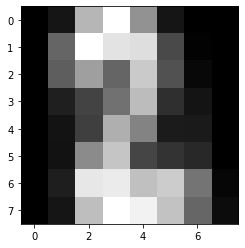

ORIGINAL


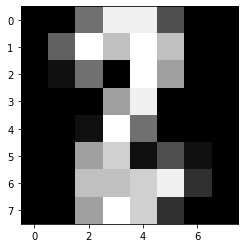

In [92]:
import matplotlib.pyplot as plt

def visualize(pixels):
    pixels = pixels.reshape((8,8))
    plt.imshow(pixels, cmap='gray')
    plt.show()

print('RECONSTRUCTION')
visualize(multiclass_reconstruct[30, :]) #our reconstruction
print('ORIGINAL')
visualize(multiclass_data[30, :]) #the original

The code below is already implemented for you. The two dictionaries `lab2im` and `lab2lat` map labels to the images and embeddings, respectively. The function `generate_train_with_size_and_test`will be useful to generate training sets with only a few labeled examples for every class as well as test sets from these dictionaries. 

In [93]:
lab2im = dict([(i, []) for i in labels_to_include])
for image, label in zip(multiclass_data, multiclass_labels):
    lab2im[label].append(image)

lab2lat = dict([(i, []) for i in labels_to_include])
for image, label in zip(multiclass_latent, multiclass_labels):
    lab2lat[label].append(image)

def generate_train_with_size_and_test(lab2vec, n_train_per_class, n_test_per_class, iter_number):
    train_labels, train_images = [], []
    test_labels, test_images = [], []
    for k in lab2vec:
      train_images.extend(lab2vec[k][iter_number:iter_number+n_train_per_class])
      train_labels.extend([[k]]*n_train_per_class)
      test_images.extend(lab2vec[k][-n_test_per_class:])
      test_labels.extend([[k]]*n_test_per_class)
    return np.array(train_images).T, np.array(train_labels).T, np.array(test_images).T, np.array(test_labels).T

Now implement the function `compute_average_score` which does a cross-validation-like evaluation for a given number of labeled training examples per class. 

Specifically, it should compute the average score across `crossval_iterations`. In every iteration, it calls `generate_train_with_size_and_test` with the parameters, including the current iteration number to get a fresh train and test set. Then instantiate and score a new KNN instance, with K=3 unless n_train_per_class is equal to 1 (what should K be in that case?). Use Euclidean distance.

In [112]:
def compute_average_score(lab2vec, n_train_per_class, n_test_per_class, crossval_iterations):
    ''' 
    Parameters: 
      lab2vec: either lab2im or lab2lat
      n_train_per_class: the number of labeled training samples per class
      n_test_per_class: the number of test samples per class
      crossval_iterations: the number of iterations to evaluate a KNN
    Returns:
      score: a float between 0 and 1
    '''
    score = 0
    for i in range(crossval_iterations):
        trainX, trainY, testX, testY = generate_train_with_size_and_test(lab2vec, n_train_per_class, n_test_per_class, i)
        if n_train_per_class != 1:
            knn = KNN(3, euclidean, trainX, trainY)
        else:
            knn = KNN(1, euclidean, trainX, trainY)
        score += knn.score(testX, testY)
    return score/crossval_iterations

Now use `compute_average_score` to test KNN for various numbers of labeled training samples per class. The code below then generates a common plot in machine learning, namely the learning curve: a plot of accuracy versus training set size. 

[0.9729999999999996, 0.9757142857142851, 0.9859642857142851, 0.9944642857142854, 0.9979285714285715, 0.9993928571428572] [0.944499999999999, 0.9633214285714286, 0.9768928571428565, 0.9862142857142854, 0.9957142857142857, 0.9977142857142851]


Text(0, 0.5, 'accuracy')

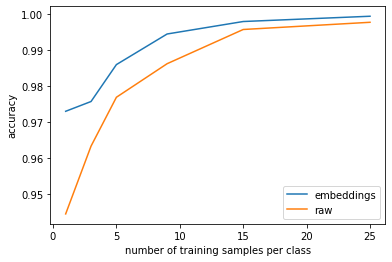

In [113]:
#don't modify this
test_samples_per_class = 140
crossval_iterations = 100

num_labeled_samples = [1, 3, 5, 9, 15, 25]
embedding_scores = [compute_average_score(lab2lat, i, test_samples_per_class, crossval_iterations) for i in num_labeled_samples]
raw_scores = [compute_average_score(lab2im, i, test_samples_per_class, crossval_iterations) for i in num_labeled_samples]

print(embedding_scores, raw_scores)
plt.plot(num_labeled_samples, embedding_scores, label='embeddings')
plt.plot(num_labeled_samples, raw_scores, label='raw')
plt.legend()
plt.xlabel('number of training samples per class')
plt.ylabel('accuracy')

**B)** What is the mean accuracy using cross-validation of KNN with Euclidean distance on the embeddings when only a single labeled example is available per class? Does this match your expectation?

**C)** What is the mean accuracy using cross-validation of KNN with Euclidean distance on the raw pixels when only a single labeled example is available per class? Does this match your expectation?

**D)** What is the mean accuracy using cross-validation of KNN with Euclidean distance on the embeddings for the following numbers of labeled examples per class: 3, 5, 9, 15, 25?

**E)** What is the mean accuracy using cross-validation of KNN with Euclidean distance on the raw pixels for the following numbers of labeled examples per class: 3, 5, 9, 15, 25?

**F)** What performs best on this dataset when only a few labeled examples are available: doing KNN on the embeddings or on the raw pixels?
